# Rewriting the code more compactly

This code does the same thing as "ols_simple" but it is written in a more object oriented way. While at this stage you may not be convinced why this is useful, it will become clearer as we turn the code into a full blown Monte Carlo simulation.

In [2]:
# loading modules
using LinearAlgebra
using Statistics
using Random
using Plots

In [3]:
# defining composite types that
# serve as containers to store results

struct Parameters
    n::Int64
    beta_0::Float64
    beta_1::Float64
end

struct Sample
    x::Array{Float64,2}
    y::Array{Float64,1}
end

struct OLS_results
    bols::Array{Float64,1}
    se_hom::Array{Float64,1}
    se_het::Array{Float64,1}
    ci_hom::Array{Float64,1}
    ci_het::Array{Float64,1}
end

struct Simresults
    bols::Array{Float64,1}
    cilb::Array{Float64,1}
    ciub::Array{Float64,1}
end

# Defining useful functions

In [4]:
"""
    sample(parms)

Creates one random sample according to linear model
Y = α + β X + e

Requires Parameters object as argument.

"""
function sample(parms::Parameters)

    # creating sample

    # exogenous variables: simply set as normal rvs
    X = [ones(parms.n, 1) randn(parms.n)]
    e = randn(parms.n) 

    # creating endogenous variables    
    Y = X*[parms.beta_0; parms.beta_1] + e;
    
    # returning Sample object
    Sample(X, Y)
    
end

sample

In [5]:
"""
    ols(X, Y)

Computes OLS estimate, its standard error, and the corresponding 95% confidence interval.

Requires Nx2 dimensional data matrix X, and Nx1 dimensional data vector Y as input.
"""

function ols(X::Array{Float64,2}, Y::Array{Float64,1})
    
    xxinv = inv(X'*X)
   
    bols = xxinv*X'*Y
    
    ehat = Y - X*bols;
    shat = ehat'*ehat/length(ehat);

    Avar_hom = shat[1]*inv(X'*X);
    Avar_het = xxinv * (X'*Diagonal(ehat.^2)*X) * xxinv;

    se_hom = diag(Avar_hom).^(0.5)
    se_het = diag(Avar_het).^(0.5)
    
    ci_hom = [bols[2] - 1.96*se_hom[2], bols[2] + 1.96*se_hom[2]]
    ci_het = [bols[2] - 1.96*se_het[2], bols[2] + 1.96*se_het[2]]
    
    # returning OLS_results object
    OLS_results(bols, se_hom, se_het, ci_hom, ci_het)

end

ols (generic function with 1 method)

In [6]:
"""
    simulate(parms, reps)

Creates #reps OLS estimates and the resulting confidence intervals.

The returned output can be seen as the simulated distributions.

"""
function simulate(parms::Parameters, reps::Int64=5000)
    
    b = zeros(reps) # collects all ols slope estimates
    lb = zeros(reps) # collects ci lower bounds
    ub = zeros(reps) # collects ci upper bounds    
    
    for r = 1:reps
        
        ss = sample(parms)
        
        b[r] = ols(ss.x, ss.y).bols[2] 
        lb[r] = ols(ss.x, ss.y).ci_het[1]
        ub[r] = ols(ss.x, ss.y).ci_het[2]
    end
    
    # returning simulation result object
    Simresults(b, lb, ub)
    
end

simulate

# OLS simulation
Here I am going to plot the finite sample distribution and look at the simulated confidence intervals.

In [7]:
# setting parameters
# DGP is Y = α + β X + e
α, β = 20, 12
N = 1000 # sample size
parms = Parameters(N, α, β);

In [8]:
bols_dstn = simulate(parms);

In [9]:
# finite sample distribution, it's just a histogram!
histogram(bols_dstn.ciub, title="Simulated distribution of OLS slope estimator", label="", color="#268bd2")

savefig("simulated_distribution");

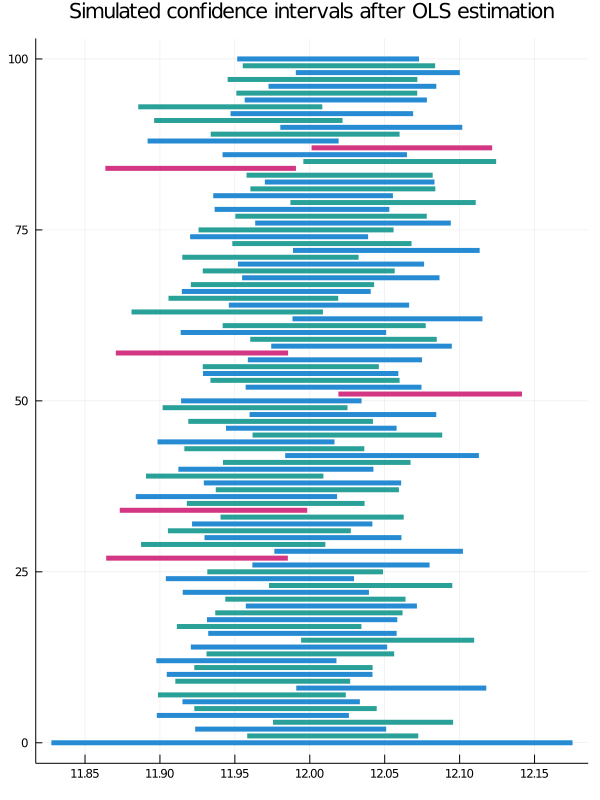

In [10]:
# primitive function to visualize the many confidence intervals we simulated
colsel = ["#268bd2", "#2aa198"]
i = 0
f(x) = i
plot(f,[minimum(bols_dstn.cilb),maximum(bols_dstn.ciub)], 
        title="Simulated confidence intervals after OLS estimation",
        lw=5, label="", linecolor="#268bd2", size=(600,800))

for i = 1:100 # don't plot too many ci's!

    f(x) = i
    if bols_dstn.cilb[i]>parms.beta_1
        Plots.display(plot!(f, [bols_dstn.cilb[i], bols_dstn.ciub[i]], lw=5, label="", linecolor="#d33682"))
    elseif bols_dstn.ciub[i]<parms.beta_1
        Plots.display(plot!(f, [bols_dstn.cilb[i], bols_dstn.ciub[i]], lw=5, label="", linecolor="#d33682"))
    else
        Plots.display(plot!(f, [bols_dstn.cilb[i], bols_dstn.ciub[i]], lw=5, label="", linecolor=colsel[isodd(i)+1]))
    end
    IJulia.clear_output(true) # needed to keep plot
        
end

savefig("simulated_confidence_intervals")